In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/project_ct/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh                         2.3.3
branca

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
MAX_FEATURES = 200000 # number of words in the vocab

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
batch_x,batch_y=dataset.as_numpy_iterator().next()

In [ ]:
batch_x.shape

(16, 1800)

In [ ]:
batch_y.shape


(16, 6)

In [ ]:
int(len(dataset)*.7)

6981

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
train_generator=train.as_numpy_iterator()
train_generator.next()

(array([[ 30203,   6511,  12851, ...,      0,      0,      0],
        [    46,    114,     14, ...,      0,      0,      0],
        [    77,      1,    598, ...,      0,      0,      0],
        ...,
        [116687,     45,    539, ...,      0,      0,      0],
        [   281,    376,     26, ...,      0,      0,      0],
        [    29,    195,   1034, ...,      0,      0,      0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 6)                 774       
                                                      

In [ ]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [ ]:
import keras,os
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 6)                 774       
                                                      

In [ ]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 624s 88ms/step - loss: 0.0624 - val_loss: 0.0465


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=100,generator=train, validation_data= val, validation_steps=10,epochs=100,callbacks=[checkpoint,early])

Epoch 1/100


<ipython-input-51-b4e496098a78>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=100,generator=train, validation_data= val, validation_steps=10,epochs=100,callbacks=[checkpoint,early])


100/100 [==============================] - ETA: 0s - loss: 0.0533

100/100 [==============================] - 10s 98ms/step - loss: 0.0533 - val_loss: 0.0503
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.0413

100/100 [==============================] - 11s 110ms/step - loss: 0.0413 - val_loss: 0.0489
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.0485

100/100 [==============================] - 11s 109ms/step - loss: 0.0485 - val_loss: 0.0509
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.0487

100/100 [==============================] - 9s 89ms/step - loss: 0.0487 - val_loss: 0.0436
Epoch 5/100
100/100 [==============================] - ETA: 0s - loss: 0.0464

100/100 [==============================] - 9s 88ms/step - loss: 0.0464 - val_loss: 0.0334
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 0.0448

100/100 [==============================] - 9s 94ms/step - loss: 0.0448 - val_loss: 0.0337
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 0.0461

100/100 [==============================] - 9s 88ms/step - loss: 0.0461 - val_loss: 0.0412
Epoch 8/100
100/100 [==============================] - ETA: 0s - loss: 0.0496

100/100 [==============================] - 9s 87ms/step - loss: 0.0496 - val_loss: 0.0420
Epoch 9/100
100/100 [==============================] - ETA: 0s - loss: 0.0504

100/100 [==============================] - 9s 86ms/step - loss: 0.0504 - val_loss: 0.0636
Epoch 10/100
100/100 [==============================] - ETA: 0s - loss: 0.0427

100/100 [==============================] - 9s 88ms/step - loss: 0.0427 - val_loss: 0.0506
Epoch 11/100
100/100 [==============================] - ETA: 0s - loss: 0.0531

100/100 [==============================] - 9s 88ms/step - loss: 0.0531 - val_loss: 0.0328
Epoch 12/100
100/100 [==============================] - ETA: 0s - loss: 0.0463

100/100 [==============================] - 9s 90ms/step - loss: 0.0463 - val_loss: 0.0443
Epoch 13/100
100/100 [==============================] - ETA: 0s - loss: 0.0504

100/100 [==============================] - 9s 91ms/step - loss: 0.0504 - val_loss: 0.0324
Epoch 14/100
100/100 [==============================] - ETA: 0s - loss: 0.0507

100/100 [==============================] - 9s 90ms/step - loss: 0.0507 - val_loss: 0.0543
Epoch 15/100
100/100 [==============================] - ETA: 0s - loss: 0.0487

100/100 [==============================] - 9s 90ms/step - loss: 0.0487 - val_loss: 0.0423
Epoch 16/100
100/100 [==============================] - ETA: 0s - loss: 0.0477

100/100 [==============================] - 9s 90ms/step - loss: 0.0477 - val_loss: 0.0506
Epoch 17/100
100/100 [==============================] - ETA: 0s - loss: 0.0396

100/100 [==============================] - 9s 89ms/step - loss: 0.0396 - val_loss: 0.0376
Epoch 18/100
100/100 [==============================] - ETA: 0s - loss: 0.0429

100/100 [==============================] - 9s 89ms/step - loss: 0.0429 - val_loss: 0.0379
Epoch 19/100
100/100 [==============================] - ETA: 0s - loss: 0.0505

100/100 [==============================] - 9s 90ms/step - loss: 0.0505 - val_loss: 0.0280
Epoch 20/100
100/100 [==============================] - ETA: 0s - loss: 0.0419

100/100 [==============================] - 9s 91ms/step - loss: 0.0419 - val_loss: 0.0389
Epoch 21/100
100/100 [==============================] - ETA: 0s - loss: 0.0400

100/100 [==============================] - 9s 90ms/step - loss: 0.0400 - val_loss: 0.0396
Epoch 22/100
100/100 [==============================] - ETA: 0s - loss: 0.0481

100/100 [==============================] - 9s 90ms/step - loss: 0.0481 - val_loss: 0.0508
Epoch 23/100
100/100 [==============================] - ETA: 0s - loss: 0.0497

100/100 [==============================] - 9s 89ms/step - loss: 0.0497 - val_loss: 0.0359
Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 0.0483

100/100 [==============================] - 9s 91ms/step - loss: 0.0483 - val_loss: 0.0411
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 0.0416

100/100 [==============================] - 9s 91ms/step - loss: 0.0416 - val_loss: 0.0387
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 0.0442

100/100 [==============================] - 9s 90ms/step - loss: 0.0442 - val_loss: 0.0480
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 0.0502

100/100 [==============================] - 9s 90ms/step - loss: 0.0502 - val_loss: 0.0588
Epoch 28/100
100/100 [==============================] - ETA: 0s - loss: 0.0391

100/100 [==============================] - 10s 99ms/step - loss: 0.0391 - val_loss: 0.0473
Epoch 29/100
100/100 [==============================] - ETA: 0s - loss: 0.0492

100/100 [==============================] - 9s 89ms/step - loss: 0.0492 - val_loss: 0.0355
Epoch 30/100
100/100 [==============================] - ETA: 0s - loss: 0.0390

100/100 [==============================] - 9s 87ms/step - loss: 0.0390 - val_loss: 0.0297
Epoch 31/100
100/100 [==============================] - ETA: 0s - loss: 0.0401

100/100 [==============================] - 9s 88ms/step - loss: 0.0401 - val_loss: 0.0400
Epoch 32/100
100/100 [==============================] - ETA: 0s - loss: 0.0472

100/100 [==============================] - 9s 87ms/step - loss: 0.0472 - val_loss: 0.0289
Epoch 33/100
100/100 [==============================] - ETA: 0s - loss: 0.0460

100/100 [==============================] - 9s 89ms/step - loss: 0.0460 - val_loss: 0.0286
Epoch 34/100
100/100 [==============================] - ETA: 0s - loss: 0.0470

100/100 [==============================] - 9s 92ms/step - loss: 0.0470 - val_loss: 0.0580
Epoch 35/100
100/100 [==============================] - ETA: 0s - loss: 0.0501

100/100 [==============================] - 9s 89ms/step - loss: 0.0501 - val_loss: 0.0301
Epoch 36/100
100/100 [==============================] - ETA: 0s - loss: 0.0465

100/100 [==============================] - 9s 90ms/step - loss: 0.0465 - val_loss: 0.0316
Epoch 37/100
100/100 [==============================] - ETA: 0s - loss: 0.0431

100/100 [==============================] - 9s 91ms/step - loss: 0.0431 - val_loss: 0.0382
Epoch 38/100
100/100 [==============================] - ETA: 0s - loss: 0.0444

100/100 [==============================] - 9s 92ms/step - loss: 0.0444 - val_loss: 0.0275
Epoch 39/100
100/100 [==============================] - ETA: 0s - loss: 0.0414

100/100 [==============================] - 9s 90ms/step - loss: 0.0414 - val_loss: 0.0522
Epoch 40/100
100/100 [==============================] - ETA: 0s - loss: 0.0484

100/100 [==============================] - 9s 89ms/step - loss: 0.0484 - val_loss: 0.0330
Epoch 41/100
100/100 [==============================] - ETA: 0s - loss: 0.0367

100/100 [==============================] - 9s 91ms/step - loss: 0.0367 - val_loss: 0.0460
Epoch 42/100
100/100 [==============================] - ETA: 0s - loss: 0.0462

100/100 [==============================] - 9s 90ms/step - loss: 0.0462 - val_loss: 0.0471
Epoch 43/100
100/100 [==============================] - ETA: 0s - loss: 0.0423

100/100 [==============================] - 9s 89ms/step - loss: 0.0423 - val_loss: 0.0397
Epoch 44/100
100/100 [==============================] - ETA: 0s - loss: 0.0448

100/100 [==============================] - 9s 92ms/step - loss: 0.0448 - val_loss: 0.0454
Epoch 45/100
100/100 [==============================] - ETA: 0s - loss: 0.0453

100/100 [==============================] - 9s 89ms/step - loss: 0.0453 - val_loss: 0.0389
Epoch 46/100
100/100 [==============================] - ETA: 0s - loss: 0.0426

100/100 [==============================] - 9s 90ms/step - loss: 0.0426 - val_loss: 0.0245
Epoch 47/100
100/100 [==============================] - ETA: 0s - loss: 0.0503

100/100 [==============================] - 9s 90ms/step - loss: 0.0503 - val_loss: 0.0366
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 0.0448

100/100 [==============================] - 9s 89ms/step - loss: 0.0448 - val_loss: 0.0510
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 0.0455

100/100 [==============================] - 9s 90ms/step - loss: 0.0455 - val_loss: 0.0298
Epoch 50/100
100/100 [==============================] - ETA: 0s - loss: 0.0486

100/100 [==============================] - 9s 89ms/step - loss: 0.0486 - val_loss: 0.0686
Epoch 51/100
100/100 [==============================] - ETA: 0s - loss: 0.0497

100/100 [==============================] - 9s 91ms/step - loss: 0.0497 - val_loss: 0.0384
Epoch 52/100
100/100 [==============================] - ETA: 0s - loss: 0.0422

100/100 [==============================] - 9s 88ms/step - loss: 0.0422 - val_loss: 0.0482
Epoch 53/100
100/100 [==============================] - ETA: 0s - loss: 0.0467

100/100 [==============================] - 9s 86ms/step - loss: 0.0467 - val_loss: 0.0394
Epoch 54/100
100/100 [==============================] - ETA: 0s - loss: 0.0531

100/100 [==============================] - 10s 98ms/step - loss: 0.0531 - val_loss: 0.0470
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.0519

100/100 [==============================] - 9s 87ms/step - loss: 0.0519 - val_loss: 0.0273
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 0.0451

100/100 [==============================] - 9s 89ms/step - loss: 0.0451 - val_loss: 0.0409
Epoch 57/100
100/100 [==============================] - ETA: 0s - loss: 0.0502

100/100 [==============================] - 9s 90ms/step - loss: 0.0502 - val_loss: 0.0242
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 0.0518

100/100 [==============================] - 9s 90ms/step - loss: 0.0518 - val_loss: 0.0515
Epoch 59/100
100/100 [==============================] - ETA: 0s - loss: 0.0408

100/100 [==============================] - 9s 90ms/step - loss: 0.0408 - val_loss: 0.0303
Epoch 60/100
100/100 [==============================] - ETA: 0s - loss: 0.0347

100/100 [==============================] - 9s 90ms/step - loss: 0.0347 - val_loss: 0.0688
Epoch 61/100
100/100 [==============================] - ETA: 0s - loss: 0.0399

100/100 [==============================] - 9s 90ms/step - loss: 0.0399 - val_loss: 0.0447
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 0.0406

100/100 [==============================] - 9s 89ms/step - loss: 0.0406 - val_loss: 0.0510
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 0.0398

100/100 [==============================] - 9s 89ms/step - loss: 0.0398 - val_loss: 0.0318
Epoch 64/100
100/100 [==============================] - ETA: 0s - loss: 0.0417

100/100 [==============================] - 9s 90ms/step - loss: 0.0417 - val_loss: 0.0501
Epoch 65/100
100/100 [==============================] - ETA: 0s - loss: 0.0550

100/100 [==============================] - 9s 90ms/step - loss: 0.0550 - val_loss: 0.0316
Epoch 66/100
100/100 [==============================] - ETA: 0s - loss: 0.0446

100/100 [==============================] - 9s 89ms/step - loss: 0.0446 - val_loss: 0.0409
Epoch 67/100
100/100 [==============================] - ETA: 0s - loss: 0.0422

100/100 [==============================] - 9s 90ms/step - loss: 0.0422 - val_loss: 0.0359
Epoch 68/100
100/100 [==============================] - ETA: 0s - loss: 0.0458

100/100 [==============================] - 9s 90ms/step - loss: 0.0458 - val_loss: 0.0451
Epoch 69/100
100/100 [==============================] - ETA: 0s - loss: 0.0488

100/100 [==============================] - 9s 90ms/step - loss: 0.0488 - val_loss: 0.0298
Epoch 70/100
 81/100 [=======================>......] - ETA: 1s - loss: 0.0457

100/100 [==============================] - 7s 75ms/step - loss: 0.0457 - val_loss: 0.0298


In [ ]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

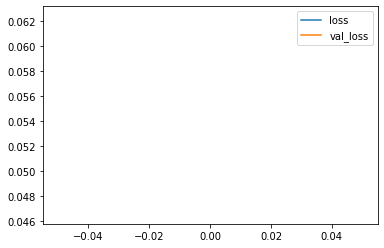

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [ ]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
batch=test.as_numpy_iterator().next()

In [ ]:
batch_x,batch_y=  test.as_numpy_iterator().next()

In [ ]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
(model.predict(batch_x)>0.5).astype(int)

1/1 [==============================] - 1s 694ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
res=model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 63ms/step


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy  

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 58ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

In [ ]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 KB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model.save('toxicity.h5')

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 672ms/step


In [ ]:
res

array([[0.32897407, 0.00331424, 0.07004197, 0.0242071 , 0.12641989,
        0.0268764 ]], dtype=float32)

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7e3ae81a-3738-4562.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
